# Question 3

## Data Read, Clean, and Summary

Below I read in the regression_data provided as a Pandas data frame and begin to clean the data before analysing the features we have to work with. This data does need some pre-processing as the tabs and spaces and considerably off. I use some simple regex to replace the weird spaceing with commas, and continue reading it in as a csv file stream.

As for unnecessary data, upon analyzing the plot graph and correlation values below we can see that 'kernel_length', 'kernel_width', and 'perimeter' are highly correlated to the 'area' field. Because of this we drop all those fields, but conserve area.

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import seed
from random import random
from pandas.compat import StringIO
import math
import sys
import re

data = ""
with open('classification_data2.txt', 'r') as myfile:
    data=myfile.read()
data = re.sub('( |\t)+',',',data)
csv_data=StringIO(data)
df = pd.read_csv(csv_data)

#Testing for nan or empty values
nan = np.array(np.where(pd.isnull(df)))
empty = np.array(np.where(df.applymap(lambda x: x == '')))

corr = df.corr(method='pearson')
indices = np.where(corr > 0.90)
indices = [(corr.index[x], corr.columns[y]) for x, y in zip(*indices) if x != y and x < y]

old_col = len(df.columns)
df = df.drop(['kernel_length', 'kernel_width', 'perimeter'], axis = 1)

features  = len(df.columns) - 1

print("-----Data Summary-----")

print("Number of Columns: " + str(old_col))
print("Number of Valid Features: " + str(features))
print("Number of Entries: " + str(df.shape[0]))

if(nan):
    print("NaN Values Found: " + str(nan))
else:
    print("NaN Values Found: None")
    
if(empty):
    print("Empty Values Found: " + str(empty))
else:
    print("Empty Values Found: None")
    
if(len(indices) > 0):
    print("Correlated Values Found: " + str(indices))
else:
    print("Empty Values Found: None")
    
print("\n-----General Dataframe Information-----\n")
print(df.describe())

def Plot(data, plot, columns, col_x,col_y):
    x = columns[col_x]
    y = columns[col_y]
    plot.set_xlabel(x)
    plot.set_ylabel(y)
    plot.set_title(x + " vs " + y)
    
    plot.scatter(data[x].values,data[y].values)

def Cross_Plot(data):
    cols = data.columns
    num_cols = features
    plt.figure(figsize=(200,150),facecolor='white')
    for col in range(0,num_cols):
            for cross_col in range(0,num_cols):
                if col != cross_col:
                    ax = plt.subplot2grid((num_cols, num_cols), (col, cross_col))
                    Plot(data, ax,cols,col, cross_col)
    
    plt.show()

Cross_Plot(df)

-----Data Summary-----
Number of Columns: 8
Number of Valid Features: 4
Number of Entries: 210
NaN Values Found: None
Empty Values Found: None
Correlated Values Found: [('area', 'perimeter'), ('area', 'kernel_length'), ('area', 'kernel_width'), ('perimeter', 'kernel_length'), ('perimeter', 'kernel_width'), ('kernel_length', 'groove_length')]

-----General Dataframe Information-----

             area  compactness        asym  groove_length        type
count  210.000000   210.000000  210.000000     210.000000  210.000000
mean    14.847524     0.870999    3.700201       5.408071    2.000000
std      2.909699     0.023629    1.503557       0.491480    0.818448
min     10.590000     0.808100    0.765100       4.519000    1.000000
25%     12.270000     0.856900    2.561500       5.045000    1.000000
50%     14.355000     0.873450    3.599000       5.223000    2.000000
75%     17.305000     0.887775    4.768750       5.877000    3.000000
max     21.180000     0.918300    8.456000       6.550

# Preparing the Data Sets

## Normalization
After we have read in and cleaned our data we can normalize all of our features and target values. We normalize each feature by using it's min-max range to scale it's values back down to a 0 to 1 range. This way all our features are on the same scale and don't have implied weight brought in by their magnitude. This is very important when used agaisn't models that use magnitude as coefficients.

## Train / Test
Once our data has been fully prepared we can form a training and testing data set. We use our larger training set to form a hypothesis, or model, on how to best reach our training target values. We then apply our trained model agaisn't our test set in order to gauge our final accuracy.

## K-Fold Cross Validation
If we only use our training set as-is we may develop a case of overfitting towards the initial training set state. In order to guard agaisnt underfitting / overfitting in our average data set we need to apply some form of cross validation. K-Fold allows us to train over a series of folds with randomized training indexes. Each fold contains a validation set formed out of a different part of the full training set. This allows us random data entries for our training sets as well as full coverage for our validation sets.

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import preprocessing

def Get_KFolds(data, y_label, num_folds):
    #Creates 5 folds from the train/test set each with a separate training and test set
    folds = []
    kf = KFold(n_splits = num_folds)
    for train_index, test_index in kf.split(data):
        training = []
        test = []
        
        train_x = data.drop(y_label, axis=1).values
        train_y = data[y_label].values
        
        #Creates a training set within the fold
        x = []
        y = []
        
        for index in train_index:
            x.append(train_x[index])
            y.append(train_y[index])
        training = [x,y]
        
        #Creates a test set within the fold
        x = []
        y = []
        for index in test_index:
            x.append(train_x[index])
            y.append(train_y[index])
        test = [x,y]

        folds.append([training,test])
    
    return folds

seed(1)

#Normalizing the data so that all the values we use are on an even playing field and 
#no feature starts with an advantage over the others
values = df.values
scaler = preprocessing.MinMaxScaler()
scaled = scaler.fit_transform(values)
normalized = pd.DataFrame(scaled,columns=df.columns)
normalized['type'] = df['type']

train_df,test_df = train_test_split(normalized,test_size=0.2)

num_folds = 5
folds = Get_KFolds(train_df, ['type'], num_folds);
train = [train_df.drop(['type'], axis = 1).values, train_df['type'].values]
test = [test_df.drop(['type'], axis = 1).values, test_df['type'].values]


## Training and Testing

### Hyper Parameter Search

For some of our algorithms there are several parameters we can set that may have profound impacts on our model and in result our predictions. For example in a polynomial algorithm the degree defines wether the polynomial is squared, cubic, etc. In order to make an informed decision on our hyper parameters we can use tools like GridSearchCV. By providing GridSearchCV with our target algorithm and some target hyperparamters we can test all our options and choose the most appropriate parameter values.

In the instance below I seperated out the search so we can see the impacts of the search and training on each algorithm and kernel. I have also set k fold cross validation to 5 on each of the searches so we guarantee our analysis is appropriately distributed and is not overfitting our initial state.

### Training and Validation

Technically we can use the GridsearchCV object to run our 'best parameters' model, but in order to see our K-Fold validation and the r2/rmse scores for each model I've included an implementation. Essentially, we step through each fold and train our model using the hyperparamters we've identified and the training set of the fold. We then use the x values of our fold validation set to predict y values and compare them agaisn't our true y values. This will allow us to calculate aour variance and rmse scores. We do this for each fold and we can form our model while validating across our full distribution. The model that has performed the best on average during this validation period can then move on to final testing.

### Test Set
After we've selected the best hyperparameters and trained our models then we can start testing our hypothesis against untouched test data we've set aside.

### Result 

Following these steps we can see that our results point to Logistic Regression as the best algorithm with a score of 0.9761904761904762. However, SVM with Hyperparameters: {'kernel': 'linear', 'C': 10}  (i.e soft SVM) will often result in equivalent if not slightly better results depending on the randomly distributed data. 

Log Hyperparameters: {'max_iter': 4000, 'C': 100}
Kernel Hyperparameters: {'kernel': 'rbf', 'gamma': 4}
SVM Hyperparameters: {'kernel': 'linear', 'C': 10}

-----Fold #1-----

	Log Score: 0.9117647058823529
	Log Score: 0.6293541389851274
	SVM Score: 0.9117647058823529

-----Fold #2-----

	Log Score: 1.0
	Log Score: 0.6683651026487485
	SVM Score: 0.9411764705882353

-----Fold #3-----

	Log Score: 1.0
	Log Score: 0.7713526244889721
	SVM Score: 1.0

-----Fold #4-----

	Log Score: 0.9393939393939394
	Log Score: 0.7232723504673961
	SVM Score: 0.9090909090909091

-----Fold #5-----

	Log Score: 0.8787878787878788
	Log Score: 0.6751922399542886
	SVM Score: 0.8787878787878788

-----Training Average-----

	Log Score: 0.9459893048128342
	Ridge Score: 0.6935072913089065
	SVM Score: 0.9281639928698753

-----Testing-----

	Log Score: 0.9761904761904762
	Ridge Score: 0.6975027536665335
	SVM Score: 0.9047619047619048


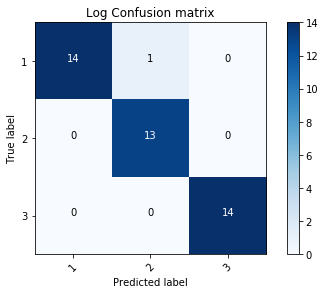

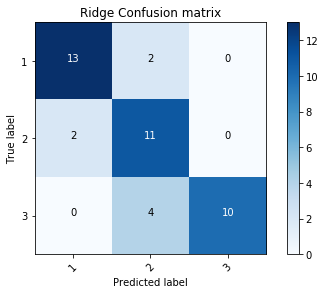

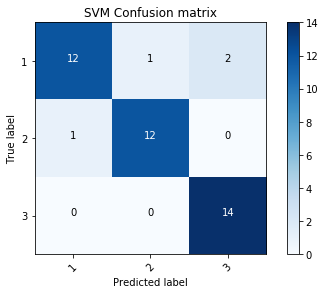

In [24]:
import gc
import itertools
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn import linear_model
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix

#Grabbed this code from sklearn reference 
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

log_cv = GridSearchCV(estimator = linear_model.LogisticRegression(solver='sag'), cv=5, param_grid = {'max_iter':[4000],'C':[0.001,0.01,0.1,1,10,100,1000]})
log_cv.fit(train[0],train[1])
log_params = log_cv.best_params_

log = linear_model.LogisticRegression(solver='sag', max_iter = [4000])
log.set_params(**log_params)

print("Log Hyperparameters: {}".format(log_params))

p_grid = [{'kernel':['linear']},
          {'kernel':['sigmoid']},
          {'kernel':['poly'],'degree':[2,3]},
          {'kernel':['rbf'],'gamma':[0.1, 0.5, 1, 2, 4]}]

ridge_cv = GridSearchCV(estimator = KernelRidge(), cv=5, param_grid = p_grid)
ridge_cv.fit(train[0],train[1])
ridge_params = ridge_cv.best_params_

ridge = KernelRidge()
ridge.set_params(**ridge_params)

print("Kernel Hyperparameters: {}".format(ridge_params))

p_grid = [{'kernel':['linear'],'C':[0.001,0.01,0.1,1,10,100,1000]},
          {'kernel':['sigmoid'],'C':[0.001,0.01,0.1,1,10,100,1000]},
          {'kernel':['poly'],'degree':[2,3],'C':[0.001,0.01,0.1,1,10,100,1000]},
          {'kernel':['rbf'],'gamma':[0.1, 0.5, 1, 2, 5],'C':[0.001,0.01,0.1,1,10,100,1000]}]

svm_cv = GridSearchCV(estimator = svm.SVC(), param_grid= p_grid, n_jobs=-1)
svm_cv.fit(train[0],train[1])
svm_params = svm_cv.best_params_

print("SVM Hyperparameters: {}".format(svm_params))

svm_m = svm.SVC()
svm_m.set_params(**svm_params)

svm_avg = 0
log_avg = 0
ridge_avg = 0

for i in range(len(folds)):
    print('\n-----Fold #{}-----\n'.format(i + 1))
    x = folds[i][0][0]
    y = np.array(folds[i][0][1]).flatten()
    
    log.fit(x,y)
    log_score = log.score(folds[i][1][0],folds[i][1][1])
    log_avg += log_score / num_folds
    
    ridge.fit(x,y)
    ridge_score = ridge.score(folds[i][1][0],folds[i][1][1])
    ridge_avg += ridge_score / num_folds
    
    svm_m.fit(x,y)
    svm_score = svm_m.score(folds[i][1][0],folds[i][1][1])
    svm_avg += svm_score / num_folds
    
    print("\tLog Score: {}".format(log_score))
    print("\tLog Score: {}".format(ridge_score))
    print("\tSVM Score: {}".format(svm_score))
    
    
print("\n-----Training Average-----\n")
print("\tLog Score: {}".format(log_avg))
print("\tRidge Score: {}".format(ridge_avg))
print("\tSVM Score: {}".format(svm_avg))


print("\n-----Testing-----\n")
score = log.score(test[0],test[1])
predictions = log.predict(test[0])
log_matrix = confusion_matrix(test[1],predictions)
print("\tLog Score: {}".format(score))

score = ridge.score(test[0],test[1])
predictions = ridge.predict(test[0]).round()
ridge_matrix = confusion_matrix(test[1],predictions)
print("\tRidge Score: {}".format(score))


score = svm_m.score(test[0],test[1])
predictions = svm_m.predict(test[0])
svm_matrix = confusion_matrix(test[1],predictions)
print("\tSVM Score: {}".format(score))
    
plot_confusion_matrix(log_matrix, classes=['1','2','3'],
                      title='Log Confusion matrix')

plt.show()

plot_confusion_matrix(ridge_matrix, classes=['1','2','3'],
                      title='Ridge Confusion matrix')

plt.show()

plot_confusion_matrix(svm_matrix, classes=['1','2','3'],
                      title='SVM Confusion matrix')

plt.show()